# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider  # Add this import
import numpy as np
from diffusion_models3d import Transformer, AbsorbingDiffusion, Block, CausalSelfAttention
from sampler_utils import retrieve_autoencoder_components_state_dicts, latent_ids_to_onehot3d, get_latent_loaders
from models3d import VQAutoEncoder, Generator
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
# from visualization_utils import MinecraftVisualizer
from data_utils import MinecraftVisualizer, get_minecraft_dataloaders, BlockConverter, MinecraftDataset
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import torch.distributions as dists
from tqdm import tqdm
import gc



In [2]:
%matplotlib widget

In [3]:
print(matplotlib.get_backend())

module://ipympl.backend_nbagg


# Visualizer

In [13]:
blocks_to_cols = {
            0: (0.5, 0.25, 0.0),    # light brown
            29: "#006400",
            38: "#B8860B",
            60: "brown",
            92: "gold",
            93: "green",
            115: "brown",
            119: "forestgreen",
            120: "forestgreen",
            194: "yellow",
            217: "gray",
            227: "#90EE90",
            240: "blue",
            40: "#2F4F4F",
            62: "#228B22",
            108: "#BEBEBE",
            131: "saddlebrown",
            132: "saddlebrown",
            95: "lightgray",
            243: "wheat",
            197: "limegreen",
            166: "orange",
            167: "#FF8C00",
            184: "#FFA07A",
            195: "tan",
            250: "white",
            251: "gold",
        }

# Working
# def draw_latent_cuboid(fig, latent_coords, size=4):
#     """
#     Draw a transparent cuboid around the specified latent coordinates.
    
#     Args:
#         fig: matplotlib figure to draw on
#         latent_coords: tuple of (d,h,w) coordinates in latent space
#         size: size of each latent cell in final space (default 4 for 6->24 upscaling)
#     """
#     def cuboid_data(o, size):
#         # o is the bottom-left-front point (x,y,z)
#         l, w, h = size
#         x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
#              [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
#              [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
#              [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
#         y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
#              [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
#              [o[1], o[1], o[1], o[1], o[1]],          
#              [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]
#         z = [[o[2], o[2], o[2], o[2], o[2]],          
#              [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],
#              [o[2], o[2], o[2] + h, o[2] + h, o[2]],  
#              [o[2], o[2], o[2] + h, o[2] + h, o[2]]]  
#         return np.array(x), np.array(y), np.array(z)

#     ax = fig.gca()
    
#     # Convert latent coordinates to final space coordinates
#     d, h, w = latent_coords
#     # flip the d
#     d = abs(5 - d)
#     origin = np.array([d*size, w*size, h*size])  # Swap d,h,w to match voxel transformation
    
#     # Create cuboid data
#     X, Y, Z = cuboid_data(origin, (size, size, size))
    
#     # Plot the cuboid surfaces
#     ax.plot_surface(X, Y, Z, color='red', alpha=0.1)
    
#     # Plot the edges for better visibility
#     for i in range(4):
#         ax.plot(X[i], Y[i], Z[i], color='red', linewidth=2)
#     for i in range(4):
#         ax.plot([X[0][i], X[1][i]], [Y[0][i], Y[1][i]], [Z[0][i], Z[1][i]], color='red', linewidth=2)
    
#     return fig
def draw_latent_cuboid(fig, latent_coords, size=4):
    """
    Draw a transparent cuboid around the specified latent coordinates.
    
    Args:
        fig: matplotlib figure to draw on
        latent_coords: list of tuples, each containing (d,h,w) coordinates
        size: size of each latent cell in final space (default 4 for 6->24 upscaling)
    """
    def cuboid_data(o, sizes):
        l, w, h = sizes
        x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
             [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
             [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
             [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
        y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
             [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
             [o[1], o[1], o[1], o[1], o[1]],          
             [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]
        z = [[o[2], o[2], o[2], o[2], o[2]],          
             [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],
             [o[2], o[2], o[2] + h, o[2] + h, o[2]],  
             [o[2], o[2], o[2] + h, o[2] + h, o[2]]]  
        return np.array(x), np.array(y), np.array(z)

    ax = fig.gca()
    
    # Convert coordinates to numpy array for easier manipulation
    coords = np.array(latent_coords)
    
    # Find min and max for each dimension
    d_min, h_min, w_min = coords.min(axis=0)
    d_max, h_max, w_max = coords.max(axis=0)
    
    # Calculate origin and sizes
    origin = np.array([abs(5 - d_max)*size, w_min*size, h_min*size])
    sizes = (
        abs(d_max - d_min + 1) * size,  # length
        (w_max - w_min + 1) * size,     # width
        (h_max - h_min + 1) * size      # height
    )
    
    # Create and draw single cuboid
    X, Y, Z = cuboid_data(origin, sizes)
    ax.plot_surface(X, Y, Z, color='red', alpha=0.1)
    
    # Plot edges
    for i in range(4):
        ax.plot(X[i], Y[i], Z[i], color='red', linewidth=1)
    for i in range(4):
        ax.plot([X[0][i], X[1][i]], [Y[0][i], Y[1][i]], [Z[0][i], Z[1][i]], 
               color='red', linewidth=2)
    
    return fig

def visualize_chunk(voxels, figsize=(10, 10), elev=20, azim=45, highlight_latents=None):
    """
    Optimized version of the 3D visualization of a Minecraft chunk.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert one-hot to block IDs if needed
    if isinstance(voxels, torch.Tensor):
        if voxels.dim() == 4:  # One-hot encoded [C,H,W,D]
            voxels = voxels.detach().cpu()
            voxels = torch.argmax(voxels, dim=0).numpy()
        else:
            voxels = voxels.detach().cpu().numpy()

    # Apply the same transformations as original
    voxels = voxels.transpose(2, 0, 1) # Moves axes from [D,H,W] to [W,D,H]
    voxels = np.rot90(voxels, 1, (0, 1))  # Rotate 90 degrees around height axis

    # Create figure and 3D axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Generate a single boolean mask for each block type
    block_masks = {block_id: (voxels == block_id) for block_id in np.unique(voxels) if block_id in blocks_to_cols}
    
    # Plot all block types with their respective colors
    for block_id, mask in block_masks.items():
        ax.voxels(mask, facecolors=blocks_to_cols[int(block_id)])
    
    # Plot remaining blocks in red with black edges
    other_vox = (voxels != 5) & (voxels != -1) & (~np.any(np.stack(list(block_masks.values())), axis=0))
    ax.voxels(other_vox, edgecolor="k", facecolor="red")
    
    # Set default view angle
    ax.view_init(elev=elev, azim=azim)

    if highlight_latents is not None:
        fig = draw_latent_cuboid(fig, highlight_latents)
    
    return fig



In [43]:
class DiffusionVisualizer:
    def __init__(self, model_path, config, gen_config, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model_path = Path(model_path)
        self.H = config  # Hyperparameter config object
        self.vq_H = gen_config
        # Load block converter
        self.block_converter = BlockConverter.load_mappings('block_mappings.pt')
        # Initialize models
        self.initialize_models()
        
    def initialize_models(self):
        """Initialize the transformer denoiser and absorbing diffusion models"""
        if not self.model_path.exists():
            raise FileNotFoundError(f"Model path {self.model_path} does not exist")
            
        # Get quantizer and embedding weights using existing helper function
        quanitzer_and_generator_state_dict = retrieve_autoencoder_components_state_dicts(
            self.H,
            ['quantize', 'generator'],
            remove_component_from_key=True
        )
        
        # Extract embedding weights
        if 'embedding.weight' in quanitzer_and_generator_state_dict:
            embedding_weight = quanitzer_and_generator_state_dict.pop('embedding.weight')
        elif 'embedding' in quanitzer_and_generator_state_dict:
            embedding_weight = quanitzer_and_generator_state_dict.pop('embedding')
        else:
            raise KeyError("Could not find embedding in state dict")
        
        embedding_weight = embedding_weight.to(self.device)

        self.generator = Generator(self.vq_H)
        self.generator.load_state_dict(quanitzer_and_generator_state_dict, strict=False)
        self.generator = self.generator.cuda()
        # Initialize transformer denoiser
        self.denoise_fn = Transformer(self.H).to(self.device)
        
        # Initialize absorbing diffusion model
        self.sampler = AbsorbingDiffusion(
            H=self.H,
            denoise_fn=self.denoise_fn,
            mask_id=self.H.codebook_size,
            embedding_weight=embedding_weight
        ).to(self.device)
        
        # Load the diffusion model state dict
        checkpoint = torch.load(self.model_path)
        
        # Load state dict with strict=False to allow for mismatches
        self.sampler.load_state_dict(checkpoint, strict=False)
        
        self.sampler.eval()
        self.denoise_fn.eval()
        
        print(f"Successfully loaded model from {self.model_path}")
        
    def generate_sample(self, n_samples=1, temp=1.0, sample_steps=100):
        """Generate a sample and return all intermediate states"""
        with torch.no_grad():
            self.sampler.n_samples = n_samples
            results = self.sampler.sample_with_intermediates(temp=temp, sample_steps=sample_steps)
            
            # Reshape everything to 3D
            states = [s.reshape(n_samples, *self.H.latent_shape) for s in results['states']]
            masks = [m.reshape(n_samples, *self.H.latent_shape) for m in results['masks']]
        
            return {
                'states': states,
                'masks': masks,
                'final': results['final'].reshape(n_samples, *self.H.latent_shape)
            }
            
    # def visualize_diffusion_steps(self, n_steps=10, temp=1.0):
    #     """Visualize the diffusion process from fully masked to complete"""
    #     with torch.no_grad():
    #         sample_steps = n_steps
    #         b = 1  # batch size
            
    #         # Initialize with all masks
    #         x_t = torch.ones((b, np.prod(self.H.latent_shape)), device=self.device).long() * self.sampler.mask_id
    #         unmasked = torch.zeros_like(x_t, device=self.device).bool()
    #         steps = np.linspace(1, self.sampler.num_timesteps, num=sample_steps).astype(np.int64)
            
    #         # Store intermediate states
    #         states = []
    #         masks = []
            
    #         for t in reversed(steps):
    #             t = torch.full((b,), t, device=self.device, dtype=torch.long)
                
    #             # Track current state
    #             states.append(x_t.clone().reshape(b, *self.H.latent_shape))
    #             masks.append(unmasked.clone().reshape(b, *self.H.latent_shape))
                
    #             # Calculate unmasking for this step
    #             changes = torch.rand(x_t.shape, device=self.device) < 1/t.float().unsqueeze(-1)
    #             changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
    #             unmasked = torch.bitwise_or(unmasked, changes)
                
    #             # Generate new tokens for unmasked positions
    #             x_0_logits = self.sampler._denoise_fn(x_t, t=t)
    #             x_0_logits = x_0_logits / temp
    #             x_0_dist = torch.distributions.Categorical(logits=x_0_logits)
    #             x_0_hat = x_0_dist.sample().long()
    #             x_t[changes] = x_0_hat[changes]
            
    #         # Add final state
    #         states.append(x_t.clone().reshape(b, *self.H.latent_shape))
    #         masks.append(unmasked.clone().reshape(b, *self.H.latent_shape))
            
    #         return states, masks

    def latents_to_blocks(self, latents, mask, mask_replacement=0):
        """Convert latent codes to Minecraft blocks using the generator"""
        with torch.no_grad():
            # Ensure everything is on the correct device
            latents = latents.to(self.device)
            mask = mask.to(self.device)
            
            # Create a copy and replace masked positions with a valid token (0)
            valid_latents = latents.clone()
            valid_latents[~mask] = mask_replacement  # Using 0 as our placeholder token
            
            # Convert to one-hot using the same function from sampler_utils
            latents_one_hot = latent_ids_to_onehot3d(
                valid_latents, 
                self.H.latent_shape, 
                self.H.codebook_size
            )
            # Reshape back to spatial dimensions
            latents_one_hot = latents_one_hot.view(
                latents.size(0),  # batch
                latents.size(1),  # D
                latents.size(2),  # H
                latents.size(3),  # W
                self.H.codebook_size
            )
            # Embed the one-hot vectors
            q = self.sampler.embed(latents_one_hot)
            
            # Generate blocks using the generator
            logits = self.generator(q.float())
            
            # Convert logits to block IDs by taking argmax along block type dimension
            blocks = torch.argmax(logits, dim=1)  # dim=1 should be the block type dimension
            # Convert to original block IDs
            blocks = self.block_converter.convert_to_original_blocks(logits)
            return blocks

    def test_single_visualization(self, results):
        """
        Test function to visualize just the final state
        """
        print("Testing single visualization...")
        mc_viz = MinecraftVisualizer()
        
        # Get final state
        final_state = results['states'][-1][0]  # Last state, first sample
        final_mask = results['masks'][-1][0]    # Last mask, first sample
        
        # Generate blocks
        blocks = self.latents_to_blocks(final_state, final_mask)
        print(f"Generated blocks shape: {blocks.shape}")
        print(f"Unique block values: {torch.unique(blocks)}")
        
        # Close any existing figures
        plt.close('all')
        
        # Create single visualization
        fig = mc_viz.visualize_chunk(blocks[0])
        # Get the axis using gca() (get current axis)
        ax = plt.gca()
        ax.set_title('Final State')
        
        return fig

   

    def visualize_4d(self, results, figsize=(10, 10)):
        """
        Create a 4D visualization of Minecraft chunks, allowing time navigation using a slider.
        
        Args:
            results: list of 3D voxel data arrays (e.g., results[t] for time t)
            figsize: tuple of (width, height) for the figure
        """
        # Precompute the visualizations
        print("Precomputing frames...")
        precomputed_images = []
        for i in range(len(results['states'])):
            current_state = results['states'][i][0]
            current_mask = results['masks'][i][0]
            blocks = self.latents_to_blocks(current_state, current_mask)
            fig = visualize_chunk(blocks[0])
            canvas = FigureCanvas(fig)
            canvas.draw()  # Draw the canvas
            img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # Extract RGB image
            img = img.reshape(canvas.get_width_height()[::-1] + (3,))  # Reshape to image format
            precomputed_images.append(img)
            plt.close(fig)  # Close the figure to save memory
            print(f"Processed step {i}/{len(results['states'])-1}")
        print("Done precomputing frames.")
        
       # Initialize the main figure for displaying images
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_axis_off()
        
        # Display the first precomputed image
        current_frame = ax.imshow(precomputed_images[0])
        
        # Define the update function
        def update_frame(idx):
            """Update the visualization when the slider moves."""
            idx = int(idx)  # Ensure the index is an integer
            current_frame.set_data(precomputed_images[idx])  # Update the displayed image
            fig.canvas.draw_idle()
        
        # Add a slider for navigating timesteps
        ax_slider = plt.axes([0.25, 0.05, 0.5, 0.03], facecolor="lightgrey")
        slider = Slider(ax_slider, 'Timestep', 0, len(results['states']) - 1, valinit=0, valstep=1)
        
        # Connect the slider to the update function
        slider.on_changed(update_frame)
        
        # Display the interactive plot
        plt.show()

    def generate_diffusion_gif(self, results, output_path='diffusion_steps.gif', duration=500, rotate=False):
        """
        Create a GIF of the diffusion process.
        
        Args:
            results: Dictionary containing states and masks from generate_sample
            output_path: Path to save the output GIF
            duration: Duration for each frame in milliseconds
            rotate: If True, rotate the view around the center (2 full rotations)
        """
        print("Generating frames...")
        frames = []
        
        # Calculate rotation angles if needed
        n_frames = len(results['states'])
        if rotate:
            azim_angles = np.linspace(45, 45 + 720, n_frames)  # Start at default 45°, do 2 full rotations (720°)
        
        for i in range(n_frames):
            current_state = results['states'][i][0]
            current_mask = results['masks'][i][0]
            blocks = self.latents_to_blocks(current_state, current_mask, mask_replacement=15)
            
            # Create figure and visualize
            if rotate:
                fig = visualize_chunk(blocks[0], elev=20, azim=azim_angles[i])
            else:
                fig = visualize_chunk(blocks[0])
            
            # Convert figure to image
            canvas = FigureCanvas(fig)
            canvas.draw()
            
            img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
            img = img.reshape(canvas.get_width_height()[::-1] + (3,))
            
            frames.append(Image.fromarray(img))
            plt.close(fig)
            print(f"Processed frame {i}/{n_frames-1}")
        
        print(f"Saving GIF to {output_path}")
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration,
            loop=0
        )
    print("Done!")

    def visualize_latent_perturbation(self, base_latent, cell_coords, n_variations=10, figsize=(10, 10)):
        """
        Visualize the effect of changing a single latent code value.
        
        Args:
            base_latent: Starting latent tensor [1, H, W, D]
            cell_coords: Tuple of (h, w, d) coordinates of cell to modify
            n_variations: Number of variations to generate
            figsize: Figure size for visualization
        """
        print("Generating variations...")
        
        # Create variations of the latent code
        variations = []
        base_value = base_latent[0, cell_coords[0], cell_coords[1], cell_coords[2]].item()
        
        for i in range(n_variations):
            # Create a copy of the base latent
            new_latent = base_latent.clone()
            # Modify the specified cell
            new_value = (base_value + (i * 10)) % self.H.codebook_size  # Wrap around if we exceed codebook size
            new_latent[0, cell_coords[0], cell_coords[1], cell_coords[2]] = new_value
            variations.append(new_latent)
        
        # Generate blocks for each variation
        print("Generating blocks...")
        precomputed_images = []
        mask = torch.ones_like(base_latent, dtype=torch.bool)  # All cells are unmasked
        
        for i, latent in enumerate(variations):
            blocks = self.latents_to_blocks(latent, mask)
            fig = visualize_chunk(blocks[0])
            canvas = FigureCanvas(fig)
            canvas.draw()
            img = np.array(canvas.buffer_rgba())[:, :, :3]  # Convert to RGB
            precomputed_images.append(img)
            plt.close(fig)
            print(f"Processed variation {i}/{n_variations-1}")
        
        print("Creating interactive visualization...")
        
        # Create the interactive visualization
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_axis_off()
        
        # Display first image
        current_frame = ax.imshow(precomputed_images[0])
        
        def update_frame(idx):
            idx = int(idx)
            current_frame.set_data(precomputed_images[idx])
            fig.canvas.draw_idle()
        
        # Add slider
        ax_slider = plt.axes([0.25, 0.05, 0.5, 0.03], facecolor="lightgrey")
        slider = Slider(
            ax_slider, 
            f'Latent Value (base={base_value})', 
            0, 
            n_variations-1, 
            valinit=0, 
            valstep=1
        )
        
        # Connect slider to update function
        slider.on_changed(update_frame)
        
        # Add title showing which cell we're modifying
        ax.set_title(f'Modifying latent at position {cell_coords}')
        
        plt.show()

    def generate_latent_perturbation_gif(self, base_latent, cell_coords, n_variations=50, 
                                   output_path='latent_perturbation.gif', duration=500, rotate=False):
        """
        Create a GIF showing the effect of changing a single latent value.
        
        Args:
            base_latent: Starting latent tensor [1, H, W, D]
            cell_coords: Tuple of (h, w, d) coordinates of cell to modify
            n_variations: Number of variations to generate
            output_path: Path to save the output GIF
            duration: Duration for each frame in milliseconds
            rotate: If True, rotate the view around the center (2 full rotations)
        """
        print("Generating variations...")
        frames = []
        base_value = base_latent[0, cell_coords[0], cell_coords[1], cell_coords[2]].item()
        mask = torch.ones_like(base_latent, dtype=torch.bool)
        
        # Calculate rotation angles if needed
        if rotate:
            azim_angles = np.linspace(45, 45 + 720, n_variations)  # Start at default 45°, do 2 full rotations
        
        for i in range(n_variations):
            # Create variation
            new_latent = base_latent.clone()
            new_value = (base_value + (i * 40)) % self.H.codebook_size
            new_latent[0, cell_coords[0], cell_coords[1], cell_coords[2]] = new_value
            
            # Generate blocks
            blocks = self.latents_to_blocks(new_latent, mask)
            
            # Create figure with visualization
            if rotate:
                fig = visualize_chunk(blocks[0], elev=20, azim=azim_angles[i], highlight_latents=cell_coords)
            else:
                fig = visualize_chunk(blocks[0], highlight_latents=cell_coords)
            
            plt.title(f'Latent value: {new_value} (base: {base_value})')
            
            # Convert to image
            canvas = FigureCanvas(fig)
            canvas.draw()
            
            img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
            img = img.reshape(canvas.get_width_height()[::-1] + (3,))
            
            frames.append(Image.fromarray(img))
            plt.close(fig)
            print(f"Processed variation {i}/{n_variations-1}")
        
        print(f"Saving GIF to {output_path}")
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration,
            loop=0
        )
        print("Done!")

    def generate_latent_slice_perturbation_gif(self, base_latent, cell_coords_list, n_variations=50, 
                                   output_path='latent_perturbation.gif', duration=500, rotate=False):
        """
        Create a GIF showing the effect of changing multiple latent values together.
        
        Args:
            base_latent: Starting latent tensor [1, H, W, D]
            cell_coords_list: List of (d,h,w) coordinate tuples to modify
            n_variations: Number of variations to generate
            output_path: Path to save the output GIF
            duration: Duration for each frame in milliseconds
            rotate: If True, rotate the view around the center (2 full rotations)
        """
        print("Generating variations...")
        frames = []
        mask = torch.ones_like(base_latent, dtype=torch.bool)
        
        # Get base values for all coordinates
        base_values = [base_latent[0, d, h, w].item() for d, h, w in cell_coords_list]
        
        # Calculate rotation angles if needed
        if rotate:
            azim_angles = np.linspace(45, 45 + 720, n_variations)
        
        for i in range(n_variations):
            # Create variation
            new_latent = base_latent.clone()
            
            # Update all coordinates with their new values
            for (d, h, w), base_value in zip(cell_coords_list, base_values):
                new_value = (base_value + (i * 40)) % self.H.codebook_size
                new_latent[0, d, h, w] = new_value
            
            # Generate blocks
            blocks = self.latents_to_blocks(new_latent, mask)
            
            # Create figure with visualization
            if rotate:
                fig = visualize_chunk(blocks[0], elev=20, azim=azim_angles[i], highlight_latents=cell_coords_list)
            else:
                fig = visualize_chunk(blocks[0], highlight_latents=cell_coords_list)
            
            plt.title(f'Increment: {i*40}')
            
            # Convert to image
            canvas = FigureCanvas(fig)
            canvas.draw()
            
            img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
            img = img.reshape(canvas.get_width_height()[::-1] + (3,))
            
            frames.append(Image.fromarray(img))
            plt.close(fig)
            print(f"Processed variation {i}/{n_variations-1}")
        
        print(f"Saving GIF to {output_path}")
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration,
            loop=0
        )
        print("Done!")

    def generate_all_latent_perturbation_gif(self, base_latent, n_variations=50, 
                                   output_path='latent_perturbation.gif', duration=500, rotate=False):
        """
        Create a GIF showing the effect of changing a single latent value.
        
        Args:
            base_latent: Starting latent tensor [1, H, W, D]
            cell_coords: Tuple of (h, w, d) coordinates of cell to modify
            n_variations: Number of variations to generate
            output_path: Path to save the output GIF
            duration: Duration for each frame in milliseconds
            rotate: If True, rotate the view around the center (2 full rotations)
        """
        print("Generating variations...")
        frames = []
        mask = torch.ones_like(base_latent, dtype=torch.bool)
        
        # Calculate rotation angles if needed
        if rotate:
            azim_angles = np.linspace(45, 45 + 720, n_variations)  # Start at default 45°, do 2 full rotations
        
        for i in range(n_variations):
            # Create variation
            # Create variation
            new_latent = base_latent.clone()
            # Add i to all values and wrap around codebook size using modulo
            new_latent = (new_latent + (i * 50)) % self.H.codebook_size
            
            # Generate blocks
            blocks = self.latents_to_blocks(new_latent, mask)
            
            # Create figure with visualization
            if rotate:
                fig = visualize_chunk(blocks[0], elev=20, azim=azim_angles[i])
            else:
                fig = visualize_chunk(blocks[0])
            
            plt.title(f'Added {i})')
            
            # Convert to image
            canvas = FigureCanvas(fig)
            canvas.draw()
            
            img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
            img = img.reshape(canvas.get_width_height()[::-1] + (3,))
            
            frames.append(Image.fromarray(img))
            plt.close(fig)
            print(f"Processed variation {i}/{n_variations-1}")
        
        print(f"Saving GIF to {output_path}")
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration,
            loop=0
        )
        print("Done!")

    def sample_large_shape(self, shape, num_samples=1, time_steps=100, step=1, temp=0.8):
        device = 'cuda'
        x_t = torch.ones((num_samples,) + shape, device=device).long() * self.sampler.mask_id
        x_lim = shape[0] - self.sampler.shape[1]  # Depth
        y_lim = shape[1] - self.sampler.shape[2]  # Height
        z_lim = shape[2] - self.sampler.shape[3]  # Width
        # print(f"Target shape: {shape}")
        # print(f"Sampler window shape: {sampler.shape}")
        # print(f"Sliding limits - x: {x_lim}, y: {y_lim}, z: {z_lim}")

        unmasked = torch.zeros_like(x_t, device=device).bool()

        autoregressive_step = 0
        for t in tqdm(list(reversed(list(range(1, time_steps+1))))):
            t = torch.full((num_samples,), t, device='cuda', dtype=torch.long)

            unmasking_method = 'autoregressive'
            changes = torch.zeros(x_t.shape, device=device).bool()
            d = autoregressive_step // (shape[1] * shape[2])  # Move to next depth after H*W steps
            h = (autoregressive_step % (shape[1] * shape[2])) // shape[2]  # Move to next height after W steps
            w = autoregressive_step % shape[2]  # Move through width first
            index = (d, h, w)
            # print(f'index: {index}')
            # print(f'changes: {changes.shape}')
            changes[:, index[0], index[1], index[2]] = True
            unmasked = torch.bitwise_or(unmasked, changes)
            autoregressive_step += 1

            # keep track of PoE probabilities
            x_0_probs = torch.zeros((num_samples,) + shape + (self.sampler.codebook_size,), device='cuda')
            x_0_probs = x_0_probs.squeeze(1)
            # print(f"Initial x_0_probs shape: {x_0_probs.shape}")
            # keep track of counts
            count = torch.zeros((num_samples,) + shape, device='cuda')

            # TODO: Monte carlo approximate this instead
            for i in range(0, x_lim+1, step):
                for j in range(0, y_lim+1, step):
                    for k in range(0, z_lim+1, step):  # Added: Loop over z dimension
                        # collect local noisy area
                        x_t_part = x_t[:, 
                                        i:i+self.sampler.shape[1],
                                        j:j+self.sampler.shape[2],
                                        k:k+self.sampler.shape[3]]
                        
                        # print(x_t_part.shape)
                        # print(f"\nWindow position ({i}, {j}, {k})")
                        # print(f"Window shape before squeeze: {x_t_part.shape}")
                        # increment count
                        count[:, 
                            i:i+self.sampler.shape[1],
                            j:j+self.sampler.shape[2],
                            k:k+self.sampler.shape[3]] += 1.0

                        # flatten
                        x_t_part = x_t_part.reshape(x_t_part.size(0), -1)
                        # print(f'x_t_part flattened shape {x_t_part.shape}')
                        # denoise
                        x_0_logits_part = self.sampler._denoise_fn(x_t_part, t=t)
                        # print(f'x_0_logits_part.shape {x_t_part.shape}')
                        # unflatten
                        # Fixed: Reshape to 3D
                        x_0_logits_part = x_0_logits_part.reshape(
                            x_t_part.size(0),
                            self.sampler.shape[1],
                            self.sampler.shape[2],
                            self.sampler.shape[3],
                            -1
                        )

                        # multiply probabilities
                        # for mixture
                        x_0_probs[:, 
                            i:i+self.sampler.shape[1],
                            j:j+self.sampler.shape[2],
                            k:k+self.sampler.shape[3]] += torch.softmax(x_0_logits_part, dim=-1)

            # Mixture with Temperature
            x_0_probs = x_0_probs / x_0_probs.sum(-1, keepdim=True)
            C = torch.tensor(x_0_probs.size(-1)).float()
            x_0_probs = torch.softmax((torch.log(x_0_probs) + torch.log(C)) / temp, dim=-1)

            x_0_dist = dists.Categorical(probs=x_0_probs)
            x_0_hat = x_0_dist.sample().long()

            # update x_0 where anything has been masked
            x_t[changes] = x_0_hat[changes]

        
        
        return x_t

        
    @torch.no_grad()
    def process_super_sampled_latents(self, latents):
            # Add batch dimension if not present
        if len(latents.shape) == 3:
            latents = latents.unsqueeze(0)
        
        print(f"Latents shape: {latents.shape}")
        
        # Convert to one-hot
        latents_one_hot = latent_ids_to_onehot3d(latents, latents.shape, self.H.codebook_size)
        print(f"One-hot shape: {latents_one_hot.shape}")
        
        # Instead of using sampler.embed, we'll do the embedding manually
        z_flattened = latents_one_hot
        embedded = torch.matmul(z_flattened, self.sampler.embedding_weight).view(
            latents.size(0),  # Batch
            latents.size(1),  # Depth
            latents.size(2),  # Height
            latents.size(3),  # Width
            self.sampler.emb_dim   # Embedding dimension
        ).permute(0, 4, 1, 2, 3).contiguous()
        
        print(f"Embedded shape: {embedded.shape}")
        
        # Generate using VQGAN
        images = self.generator(embedded.float())
        
        return images
    
    def latents_to_blocks_super(self, latents):
        """Convert latent codes to Minecraft blocks using the generator"""
        with torch.no_grad():
            # Ensure everything is on the correct device
            latents = latents.to(self.device)
                        
            if len(latents.shape) == 3:
                latents = latents.unsqueeze(0)
            # Convert to one-hot using the same function from sampler_utils
            latents_one_hot = latent_ids_to_onehot3d(
                latents, 
                latents.shape, 
                self.H.codebook_size
            )
            # Reshape back to spatial dimensions
            latents_one_hot = latents_one_hot.view(
                latents.size(0),  # batch
                latents.size(1),  # D
                latents.size(2),  # H
                latents.size(3),  # W
                self.H.codebook_size
            ).contiguous()
            # Embed the one-hot vectors
            q = self.sampler.embed(latents_one_hot)
            q = q.contiguous()

            # Delete the sampler to free memory
            del self.sampler
            torch.cuda.empty_cache()
            print(f'q shape: {q.shape}')
            # Generate blocks using the generator
            logits = self.generator(q.float())
            print(f'logits shape: {logits.shape}')
            # Convert logits to block IDs by taking argmax along block type dimension
            blocks = torch.argmax(logits, dim=1)  # dim=1 should be the block type dimension
            print(f'blocks shape: {blocks.shape}')
            # Convert to original block IDs
            blocks = self.block_converter.convert_to_original_blocks(logits)
            return blocks
    
    def visualize_growing_chunk(self, voxels, target_shape, elev=20, azim=45):
        """
        Create a 3D visualization of a growing Minecraft chunk, maintaining consistent scaling.
        
        Args:
            voxels: The complete super-sampled voxels tensor [H,W,D]
            target_shape: Final shape tuple (H,W,D) to determine scaling
            elev: Elevation angle for viewing
            azim: Azimuth angle for viewing
        """
        # Convert tensor if needed
        if isinstance(voxels, torch.Tensor):
            if voxels.dim() == 4:  # One-hot encoded [C,H,W,D]
                voxels = voxels.detach().cpu()
                voxels = torch.argmax(voxels, dim=0).numpy()
            else:
                voxels = voxels.detach().cpu().numpy()

        # Calculate final scaling based on target shape
        default_size = 6
        scale_x = target_shape[0] / default_size
        scale_y = target_shape[1] / default_size
        scale_z = target_shape[2] / default_size
        
        # Create figure with consistent scaling
        fig = plt.figure(figsize=(8 * scale_x, 8 * scale_y))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect((scale_x, scale_y, scale_z))
        
        # Set view angle
        ax.view_init(elev=elev, azim=azim)
        
        # Apply transformations as in original
        voxels = voxels.transpose(2, 0, 1)
        voxels = np.rot90(voxels, 1, (0, 1))
        
        # Plot non-air blocks
        other_vox = (voxels != 5) & (voxels != -1)
        
        # Plot each block type with its color
        for block_id in np.unique(voxels[other_vox]):
            if block_id not in blocks_to_cols:
                continue
            ax.voxels(voxels == block_id, facecolors=blocks_to_cols[int(block_id)])
            other_vox = other_vox & (voxels != block_id)

        # Plot remaining blocks in red with black edges
        ax.voxels(other_vox, edgecolor="k", facecolor="red")
        
        return fig

    def generate_growing_gif(self, super_sampled_latents, output_path='growing_terrain.gif', 
                        duration=500, rotate=False):
        """
        Create a GIF showing the super-sampled terrain growing.
        
        Args:
            super_sampled_latents: The super-sampled latents [B, D, H, W]
            output_path: Path to save the output GIF
            duration: Duration for each frame in milliseconds
            rotate: If True, rotate the view while growing
        """
        print("Generating growing visualization...")
        frames = []
        
        # Get the final shape for consistent scaling
        final_shape = super_sampled_latents.shape[1:]  # Remove batch dimension
        n_frames = final_shape[0] - 6  # Number of frames from base shape to final shape
        
        if rotate:
            azim_angles = np.linspace(45, 45 + 720, n_frames)  # 2 full rotations
        
        print(f"Generating {n_frames} frames...")
        for i in range(n_frames):
            # Clear CUDA cache at the start of each iteration
            torch.cuda.empty_cache()
            
            # Take slice from 0 to current height (6 + i)
            current_slice = super_sampled_latents[:, :, :6+i, :]
            mask = torch.ones_like(current_slice, dtype=torch.bool)
            # Generate blocks
            blocks = self.latents_to_blocks_super(current_slice, mask)
            
            # Create visualization with consistent scaling
            if rotate:
                fig = self.visualize_growing_chunk(blocks[0], final_shape, elev=20, azim=azim_angles[i])
            else:
                fig = self.visualize_growing_chunk(blocks[0], final_shape)
            
            # Convert to image
            canvas = FigureCanvas(fig)
            canvas.draw()
            
            img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
            img = img.reshape(canvas.get_width_height()[::-1] + (3,))
            
            frames.append(Image.fromarray(img))
            plt.close(fig)
            
            print(f"Processed frame {i+1}/{n_frames}")
            
            # Force garbage collection after each frame
            torch.cuda.empty_cache()
        
        print(f"Saving GIF to {output_path}")
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration,
            loop=0
        )
        print("Done!")                   

Done!


# Load diffusion model

In [6]:
from hyperparams import HparamsAbsorbing, load_hparams_from_json, dict_to_absorbing_hparams, dict_to_vcqgan_hparams

diff_H = dict_to_absorbing_hparams(load_hparams_from_json(f"../model_logs/sampler_minecraft_ema_2"), 'maps')
vq_H = dict_to_vcqgan_hparams(load_hparams_from_json(f"../model_logs/{diff_H.ae_load_dir}"), 'maps')


In [44]:
# Create visualizer with generator
visualizer = DiffusionVisualizer(
    model_path=f"../model_logs/{diff_H['log_dir']}/saved_models/absorbing_225000.th",
    config=diff_H,
    gen_config=vq_H,
)

Loading VQGAN from ../model_logs/minecraft39ch_ce_3/saved_models/vqgan_95000.th
resolution: 24, num_resolutions: 3, num_res_blocks: 2, attn_resolutions: [6], in_channels: 256, out_channels: 39, block_in_ch: 256, curr_res: 6
Successfully loaded model from ..\model_logs\sampler_minecraft_ema_2\saved_models\absorbing_225000.th


# Visualize diffusion timesteps

In [45]:
# Generate samples with intermediates
results = visualizer.generate_sample(n_samples=1, temp=1.0, sample_steps=100)
visualizer.generate_diffusion_gif(results, output_path='diffusion_gif_15mask.gif', rotate=False, duration=200)
# visualizer.visualize_4d(results)

Generating frames...


C:\Users\TimBits\AppData\Local\Temp\ipykernel_60420\1885760695.py:263: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processed frame 0/100
Processed frame 1/100
Processed frame 2/100
Processed frame 3/100
Processed frame 4/100
Processed frame 5/100
Processed frame 6/100
Processed frame 7/100
Processed frame 8/100
Processed frame 9/100
Processed frame 10/100
Processed frame 11/100
Processed frame 12/100
Processed frame 13/100
Processed frame 14/100
Processed frame 15/100
Processed frame 16/100
Processed frame 17/100
Processed frame 18/100
Processed frame 19/100
Processed frame 20/100
Processed frame 21/100
Processed frame 22/100
Processed frame 23/100
Processed frame 24/100
Processed frame 25/100
Processed frame 26/100
Processed frame 27/100
Processed frame 28/100
Processed frame 29/100
Processed frame 30/100
Processed frame 31/100
Processed frame 32/100
Processed frame 33/100
Processed frame 34/100
Processed frame 35/100
Processed frame 36/100
Processed frame 37/100
Processed frame 38/100
Processed frame 39/100
Processed frame 40/100
Processed frame 41/100
Processed frame 42/100
Processed frame 43/10

# Latent Perturbation

## Loading all training latents and looking for interesting ones to visualize perturbations on

In [ ]:
# # Load latents
# train_loader, val_loader = get_latent_loaders(diff_H, get_validation_loader=True, shuffle=True)

# # Get first 10 samples
# sample_latents = []
# for batch in train_loader:
#     print(batch.size())
#     sample_latents.append(batch[0])  # Get first sample from batch
#     if len(sample_latents) >= 10:
#         break

# sample_latents
# # Visualize each sample
# print("Visualizing 10 samples...")
# for i, latent in enumerate(sample_latents):
#     # Reshape to [1, H, W, D] if needed
#     latent = latent.reshape(1, *diff_H.latent_shape)
#     # latent = latent.unsqueeze(0) if latent.dim() == 3 else latent
    
#     # Create mask (all True)
#     mask = torch.ones_like(latent, dtype=torch.bool)
    
#     # Generate blocks
#     blocks = visualizer.latents_to_blocks(latent, mask)
    
#     # Visualize
#     plt.figure(figsize=(8, 8))
#     fig = visualize_chunk(blocks[0])
#     plt.title(f"Sample {i}")
#     plt.show()
    
#     # Save the latent
#     torch.save(latent, f"sample_latent_{i}.pt")
#     print(f"Saved sample_{i} to sample_latent_{i}.pt")

# Going from latent coords to block coords
If we're trying to address a latent at location ()


## Visualize perturbations


In [48]:
base_sample_blocks.shape

torch.Size([1, 24, 24, 24])

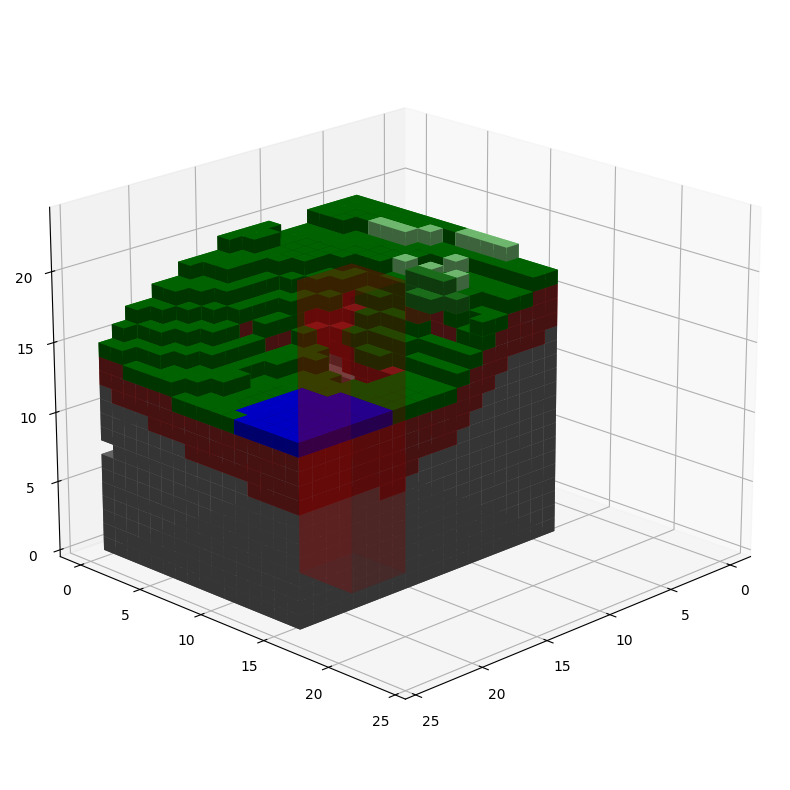

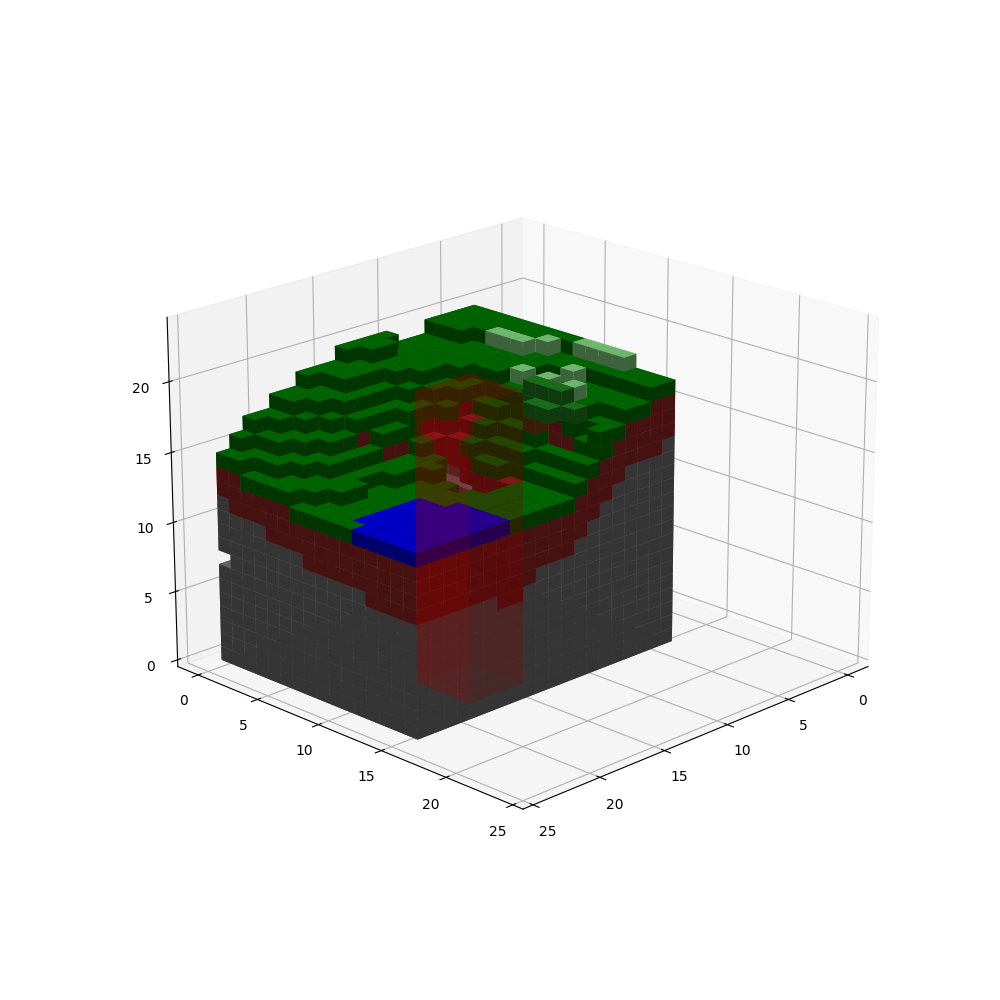

In [51]:
base_latent = torch.load("sample latents/sample_latent_2.pt").squeeze(0)

mask = torch.ones_like(base_latent, dtype=torch.bool)
base_sample_blocks = visualizer.latents_to_blocks(base_latent, mask)
base_sample_blocks[0, :, :, 16:] = 5
visualize_chunk(base_sample_blocks[0], highlight_latents=[(0, 1, 4), (0, 2, 4), (0, 3, 4), (0, 4, 4), (0, 5, 4)])

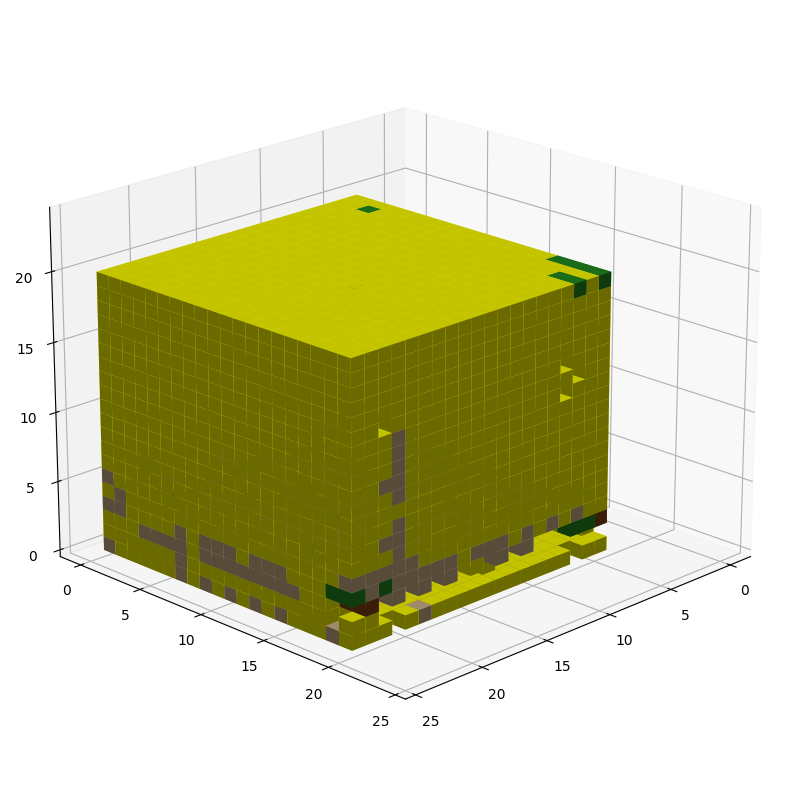

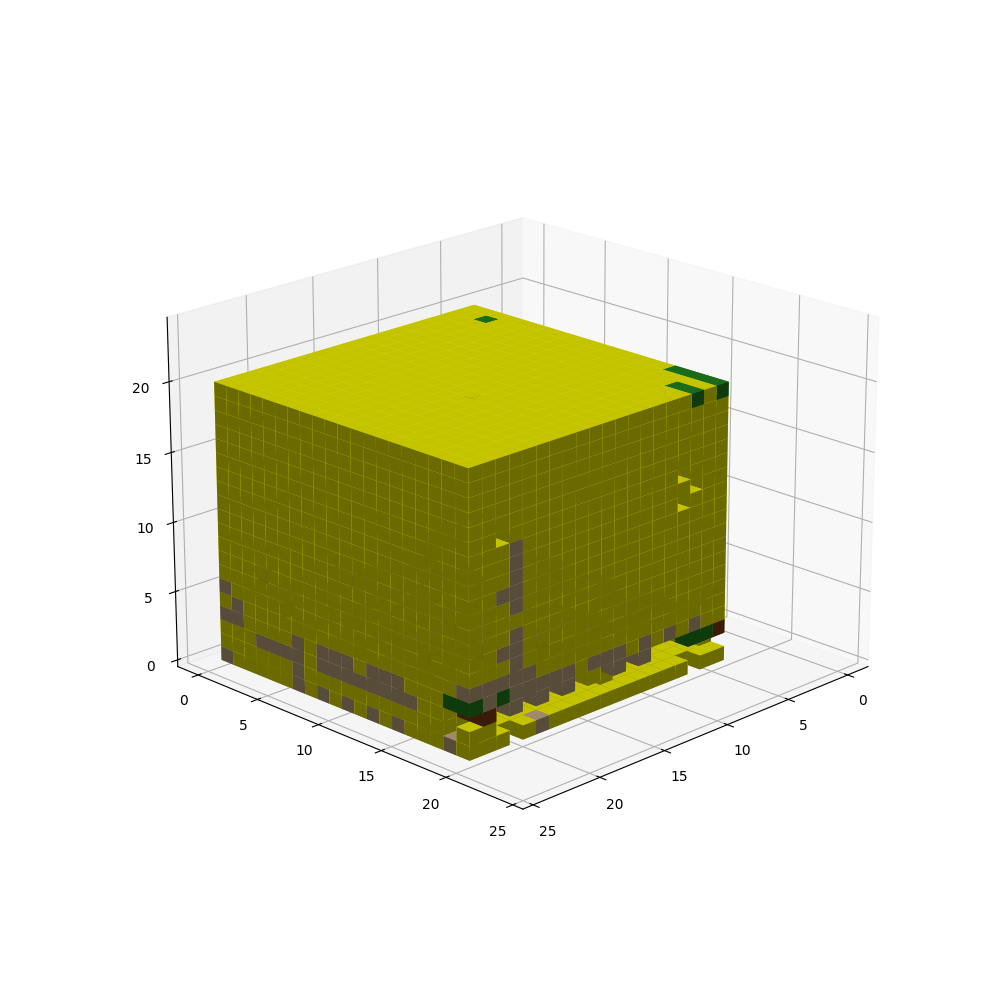

In [42]:
test = torch.ones_like(base_latent, dtype=torch.int64) * 15
mask = torch.ones_like(base_latent, dtype=torch.bool)
test_sample_blocks = visualizer.latents_to_blocks(test, mask)
visualize_chunk(test_sample_blocks[0])

In [ ]:
for every training_latent:
    reconstructed_chunk = generator(training_latent)
    for codebook_idx in range(512):
        look up all locations where codebook_idx appears in training latents
        retrieve 4x4x4 cunk from reconstructed_chunk
        

In [32]:
test.shape

torch.Size([1, 6, 6, 6])

In [114]:
# Load an interesting sample (replace X with the sample number you chose)
base_latent = torch.load("sample latents/sample_latent_2.pt").squeeze(0)

# Test the perturbation visualization
# cell_coords = (5, 3, 0)  # We can adjust these coordinates based on where interesting features are


for i in range(6):

    cell_coords = (0, i, 5) 
    visualizer.generate_latent_perturbation_gif(
        base_latent=base_latent,
        cell_coords=cell_coords,
        n_variations=10,
        duration=200,
        output_path='latent_perturbation_2_' + ''.join([str(x) for x in cell_coords]) + '_test4.gif'
    )

Generating variations...


C:\Users\TimBits\AppData\Local\Temp\ipykernel_22436\130052819.py:395: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processed variation 0/9
Processed variation 1/9
Processed variation 2/9
Processed variation 3/9
Processed variation 4/9
Processed variation 5/9
Processed variation 6/9
Processed variation 7/9
Processed variation 8/9
Processed variation 9/9
Saving GIF to latent_perturbation_2_005_test4.gif
Done!
Generating variations...
Processed variation 0/9
Processed variation 1/9
Processed variation 2/9
Processed variation 3/9
Processed variation 4/9
Processed variation 5/9
Processed variation 6/9
Processed variation 7/9
Processed variation 8/9
Processed variation 9/9
Saving GIF to latent_perturbation_2_015_test4.gif
Done!
Generating variations...
Processed variation 0/9
Processed variation 1/9
Processed variation 2/9
Processed variation 3/9
Processed variation 4/9
Processed variation 5/9
Processed variation 6/9
Processed variation 7/9
Processed variation 8/9
Processed variation 9/9
Saving GIF to latent_perturbation_2_025_test4.gif
Done!
Generating variations...
Processed variation 0/9
Processed var

## Slice perturbation

In [26]:
# Load an interesting sample (replace X with the sample number you chose)
base_latent = torch.load("sample latents/sample_latent_2.pt").squeeze(0)

# coords = [(x, 2, 4) for x in range(6)]  # Three vertical positions
coords = [(0, y, z) for y in range(6) for z in range(4)]
# Test the perturbation visualization
# cell_coords = (5, 3, 0)  # We can adjust these coordinates based on where interesting features are



visualizer.generate_latent_slice_perturbation_gif(
    base_latent=base_latent,
    cell_coords_list=coords,
    n_variations=10,
    duration=500,
    output_path='latent_perturbation_l2_slice_0yz.gif'
)

Generating variations...


C:\Users\TimBits\AppData\Local\Temp\ipykernel_60420\854855551.py:460: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processed variation 0/9
Processed variation 1/9
Processed variation 2/9
Processed variation 3/9
Processed variation 4/9
Processed variation 5/9
Processed variation 6/9
Processed variation 7/9
Processed variation 8/9
Processed variation 9/9
Saving GIF to latent_perturbation_l2_slice_0yz.gif
Done!


In [60]:
base_latent[0, 5, 3, 4]

tensor(308)

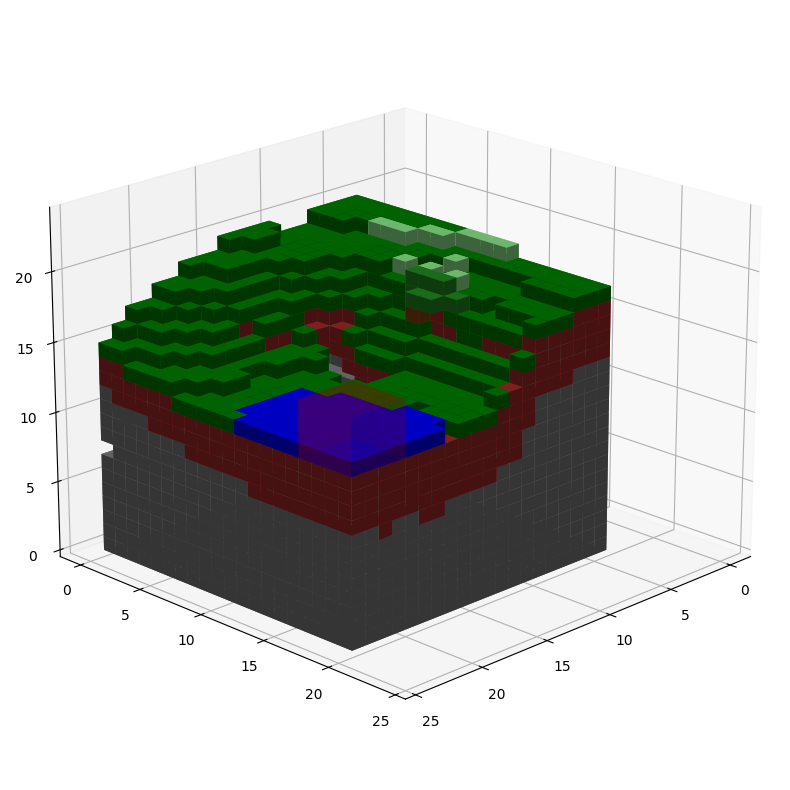

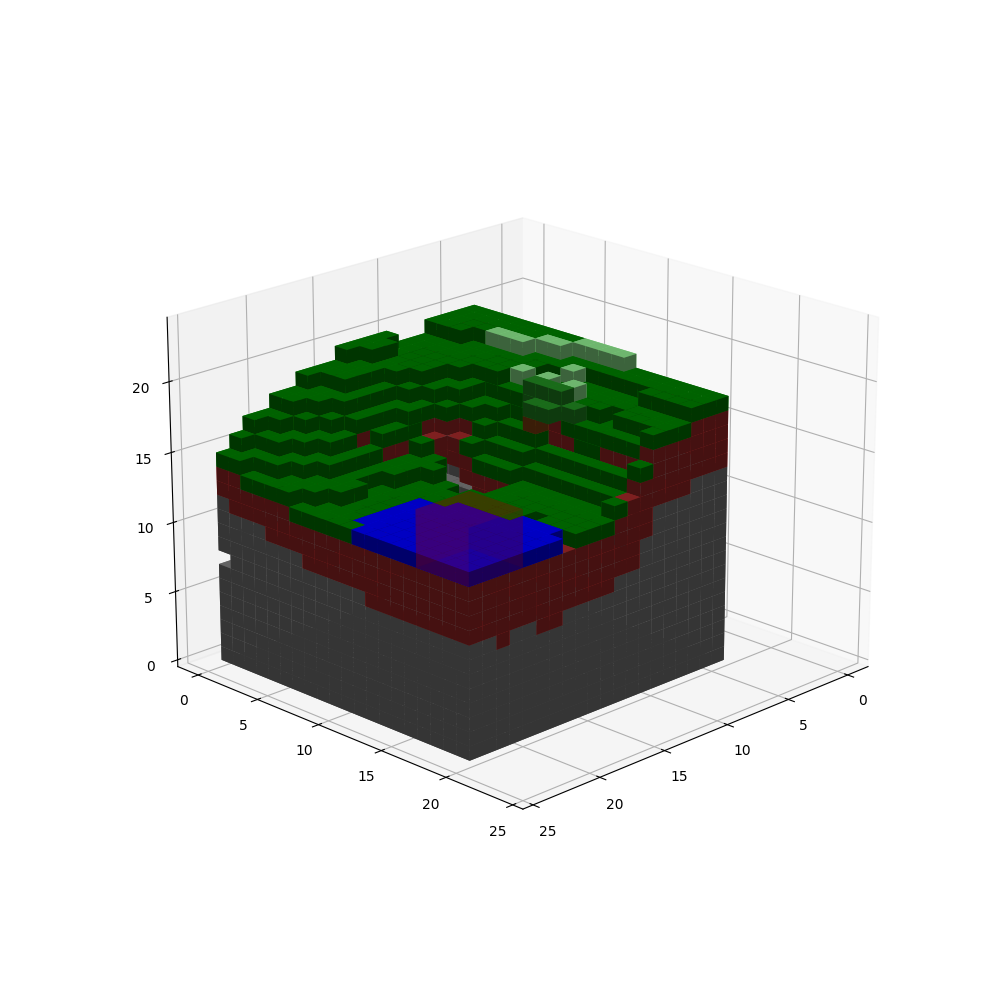

In [62]:
base_latent = torch.load("sample latents/sample_latent_2.pt").squeeze(0)
base_latent[0, 5, 3, 4] = 1
mask = torch.ones_like(base_latent, dtype=torch.bool)
base_sample_blocks = visualizer.latents_to_blocks(base_latent, mask)
visualize_chunk(base_sample_blocks[0], highlight_latents=(5, 3, 4))

## Increment all latents by 1

In [8]:
base_latent = torch.load("sample latents/sample_latent_2.pt").squeeze(0)

visualizer.generate_all_latent_perturbation_gif(
    base_latent=base_latent,
    n_variations=50,
    duration=500,
    output_path='all_latent_perturbation_l2.gif'
)

Generating variations...


C:\Users\TimBits\AppData\Local\Temp\ipykernel_22436\470500500.py:455: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processed variation 0/49
Processed variation 1/49
Processed variation 2/49
Processed variation 3/49
Processed variation 4/49
Processed variation 5/49
Processed variation 6/49
Processed variation 7/49
Processed variation 8/49
Processed variation 9/49
Processed variation 10/49
Processed variation 11/49
Processed variation 12/49
Processed variation 13/49
Processed variation 14/49
Processed variation 15/49
Processed variation 16/49
Processed variation 17/49
Processed variation 18/49
Processed variation 19/49
Processed variation 20/49
Processed variation 21/49
Processed variation 22/49
Processed variation 23/49
Processed variation 24/49
Processed variation 25/49
Processed variation 26/49
Processed variation 27/49
Processed variation 28/49
Processed variation 29/49
Processed variation 30/49
Processed variation 31/49
Processed variation 32/49
Processed variation 33/49
Processed variation 34/49
Processed variation 35/49
Processed variation 36/49
Processed variation 37/49
Processed variation 38

In [85]:
# Load an interesting sample (replace X with the sample number you chose)
base_latent = torch.load("sample latents/sample_latent_8.pt").squeeze(0)

# Test the perturbation visualization
# cell_coords = (5, 3, 0)  # We can adjust these coordinates based on where interesting features are

cell_coords = (4, 5, 5) 
# cell_coords = (5, 3, 4) 
# cell_coords = (1, 3, 4)
# visualizer.visualize_latent_perturbation(
#     base_latent=base_latent,
#     cell_coords=cell_coords,
#     n_variations=10
# )
visualizer.generate_latent_perturbation_gif(
    base_latent=base_latent,
    cell_coords=cell_coords,
    n_variations=10,
    duration=200,
    output_path='latent_perturbation_2_455_test2.gif'
)

Generating variations...


C:\Users\TimBits\AppData\Local\Temp\ipykernel_22436\130052819.py:395: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processed variation 0/9
Processed variation 1/9
Processed variation 2/9
Processed variation 3/9
Processed variation 4/9
Processed variation 5/9
Processed variation 6/9
Processed variation 7/9
Processed variation 8/9
Processed variation 9/9
Saving GIF to latent_perturbation_2_455_test2.gif
Done!


In [92]:
''.join([str(x) for x in cell_coords])

'455'

Generating variations...
Generating blocks...
Processed variation 0/24
Processed variation 1/24
Processed variation 2/24
Processed variation 3/24
Processed variation 4/24
Processed variation 5/24
Processed variation 6/24
Processed variation 7/24
Processed variation 8/24
Processed variation 9/24
Processed variation 10/24
Processed variation 11/24
Processed variation 12/24
Processed variation 13/24
Processed variation 14/24
Processed variation 15/24
Processed variation 16/24
Processed variation 17/24
Processed variation 18/24
Processed variation 19/24
Processed variation 20/24
Processed variation 21/24
Processed variation 22/24
Processed variation 23/24
Processed variation 24/24
Creating interactive visualization...


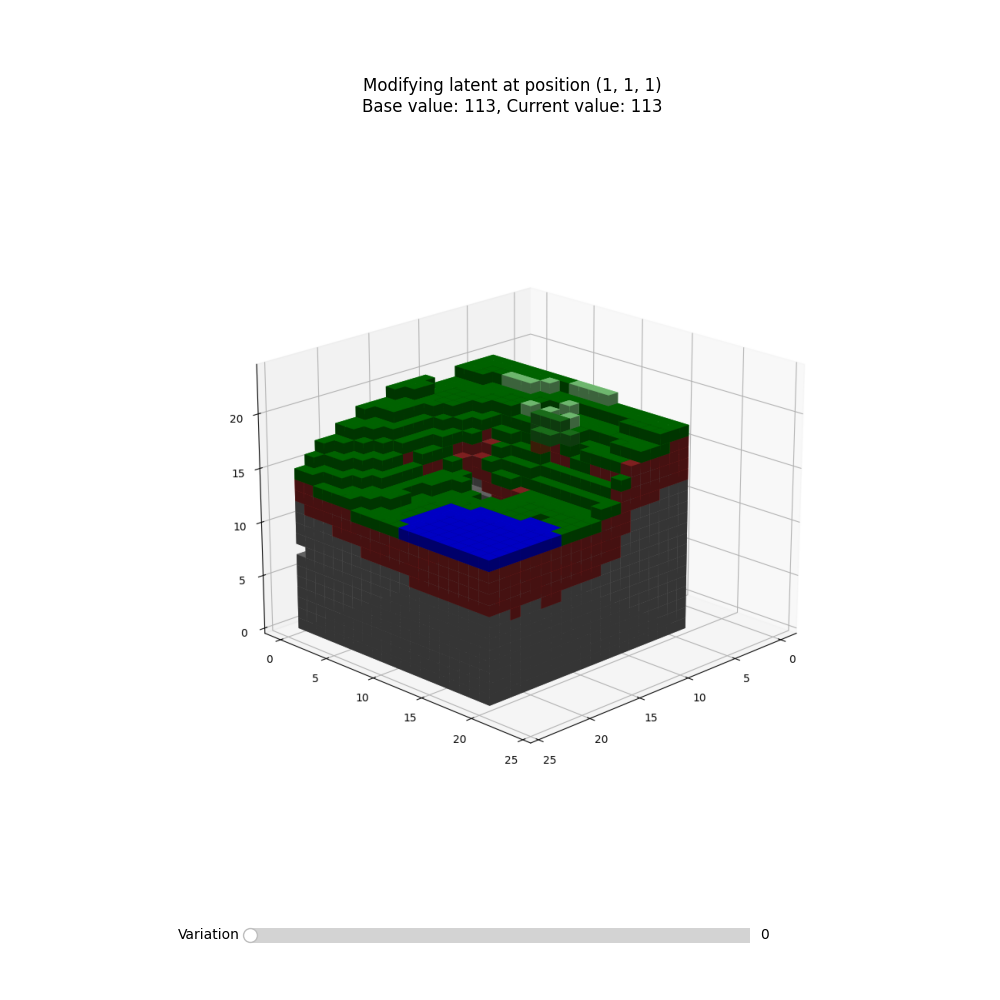

In [11]:
base_latent = torch.load("sample_latent_2.pt").squeeze(0)
plt.close('all')
# Test the perturbation visualization
cell_coords = (1, 1, 1)  # We can adjust these coordinates based on where interesting features are
visualizer.visualize_latent_perturbation(
    base_latent=base_latent,
    cell_coords=cell_coords,
    n_variations=25
)

# Super sampling

## Visualize a super sampled chunk

In [8]:
def visualize_chunk_super(voxels, max_shape, max_x=None, max_y=None, ax=None):
    """
    Create a 3D visualization of a Minecraft chunk using the original plotting logic.
    
    Args:
        voxels: torch.Tensor [C,H,W,D] (one-hot) or numpy.ndarray [H,W,D] (block IDs)
        ax: Optional matplotlib axis
    """
    # Convert one-hot to block IDs if needed
    if isinstance(voxels, torch.Tensor):
        if voxels.dim() == 4:  # One-hot encoded [C,H,W,D]
            voxels = voxels.detach().cpu()
            voxels = torch.argmax(voxels, dim=0).numpy()
        else:
            voxels = voxels.detach().cpu().numpy()

    # Apply the same transformations as original
    voxels = voxels.transpose(2, 0, 1)
    # Rotate the voxels 90 degrees around the height axis
    voxels = np.rot90(voxels, 1, (0, 1))

    # Get dimensions after rotation
    depth, height, width = max_shape
    
    # Calculate scaling factors based on 6x6x6 being the default size
    default_size = 6
    scale_x = depth / default_size
    scale_y = height / default_size
    scale_z = width / default_size
    
    # Create axis if not provided
    if ax is None:
        # Scale figure size based on dimensions
        fig = plt.figure(figsize=(8 * scale_x, 8 * scale_y))
        ax = fig.add_subplot(111, projection='3d')

    # Set the same maximum limit for x and y axes if specified
    if max_x is not None:
        ax.set_xlim(0, max_x)
    if max_y is not None:
        ax.set_ylim(0, max_y)
    # Adjust the axis aspect ratio to match the data dimensions
    ax.set_box_aspect((scale_x, scale_y, scale_z))

    # Plot non-air blocks
    other_vox = (voxels != 5) & (voxels != -1)
    
    # Plot each block type with its color
    for block_id in np.unique(voxels[other_vox]):
        if block_id not in blocks_to_cols:
            # print(f"Unknown block id: {block_id}")
            continue
        ax.voxels(voxels == block_id, facecolors=blocks_to_cols[int(block_id)])
        other_vox = other_vox & (voxels != block_id)

    # Plot remaining blocks in red with black edges
    ax.voxels(other_vox, edgecolor="k", facecolor="red")

    # Set default view angle
    ax.view_init(elev=20, azim=45)
    
    return fig

## Generate a super sample of a given shape

In [9]:
def sample_shape(sampler, shape, num_samples, time_steps=1000, step=1, temp=0.8):
    device = 'cuda'
    x_t = torch.ones((num_samples,) + shape, device=device).long() * sampler.mask_id
    x_lim = shape[0] - sampler.shape[1]  # Depth
    y_lim = shape[1] - sampler.shape[2]  # Height
    z_lim = shape[2] - sampler.shape[3]  # Width
    # print(f"Target shape: {shape}")
    # print(f"Sampler window shape: {sampler.shape}")
    # print(f"Sliding limits - x: {x_lim}, y: {y_lim}, z: {z_lim}")

    unmasked = torch.zeros_like(x_t, device=device).bool()

    autoregressive_step = 0
    for t in tqdm(list(reversed(list(range(1, time_steps+1))))):
        t = torch.full((num_samples,), t, device='cuda', dtype=torch.long)

        unmasking_method = 'autoregressive'
        changes = torch.zeros(x_t.shape, device=device).bool()
        d = autoregressive_step // (shape[1] * shape[2])  # Move to next depth after H*W steps
        h = (autoregressive_step % (shape[1] * shape[2])) // shape[2]  # Move to next height after W steps
        w = autoregressive_step % shape[2]  # Move through width first
        index = (d, h, w)
        # print(f'index: {index}')
        # print(f'changes: {changes.shape}')
        changes[:, index[0], index[1], index[2]] = True
        unmasked = torch.bitwise_or(unmasked, changes)
        autoregressive_step += 1

        # keep track of PoE probabilities
        x_0_probs = torch.zeros((num_samples,) + shape + (sampler.codebook_size,), device='cuda')
        x_0_probs = x_0_probs.squeeze(1)
        # print(f"Initial x_0_probs shape: {x_0_probs.shape}")
        # keep track of counts
        count = torch.zeros((num_samples,) + shape, device='cuda')

        # TODO: Monte carlo approximate this instead
        for i in range(0, x_lim+1, step):
            for j in range(0, y_lim+1, step):
                for k in range(0, z_lim+1, step):  # Added: Loop over z dimension
                    # collect local noisy area
                    x_t_part = x_t[:, 
                                    i:i+sampler.shape[1],
                                    j:j+sampler.shape[2],
                                    k:k+sampler.shape[3]]
                    
                    # print(x_t_part.shape)
                    # print(f"\nWindow position ({i}, {j}, {k})")
                    # print(f"Window shape before squeeze: {x_t_part.shape}")
                    # increment count
                    count[:, 
                         i:i+sampler.shape[1],
                         j:j+sampler.shape[2],
                         k:k+sampler.shape[3]] += 1.0

                    # flatten
                    x_t_part = x_t_part.reshape(x_t_part.size(0), -1)
                    # print(f'x_t_part flattened shape {x_t_part.shape}')
                    # denoise
                    x_0_logits_part = sampler._denoise_fn(x_t_part, t=t)
                    # print(f'x_0_logits_part.shape {x_t_part.shape}')
                    # unflatten
                    # Fixed: Reshape to 3D
                    x_0_logits_part = x_0_logits_part.reshape(
                        x_t_part.size(0),
                        sampler.shape[1],
                        sampler.shape[2],
                        sampler.shape[3],
                        -1
                    )

                    # multiply probabilities
                    # for mixture
                    x_0_probs[:, 
                        i:i+sampler.shape[1],
                        j:j+sampler.shape[2],
                        k:k+sampler.shape[3]] += torch.softmax(x_0_logits_part, dim=-1)

        # Mixture with Temperature
        x_0_probs = x_0_probs / x_0_probs.sum(-1, keepdim=True)
        C = torch.tensor(x_0_probs.size(-1)).float()
        x_0_probs = torch.softmax((torch.log(x_0_probs) + torch.log(C)) / temp, dim=-1)

        x_0_dist = dists.Categorical(probs=x_0_probs)
        x_0_hat = x_0_dist.sample().long()

        # update x_0 where anything has been masked
        x_t[changes] = x_0_hat[changes]

    return x_t

@torch.no_grad()
def process_super_sampled_latents(latents, sampler, generator, H):
    """
    Convert super-sampled latents to blocks using the generator.
    
    Args:
        latents: The super-sampled latents of shape [D, H, W]
        sampler: The trained sampler model
        generator: The VQGAN generator
        H: Hyperparameters
    
    Returns:
        The generated blocks
    """
    # Add batch dimension if not present
    if len(latents.shape) == 3:
        latents = latents.unsqueeze(0)
    
    print(f"Latents shape: {latents.shape}")
    
    # Convert to one-hot
    latents_one_hot = latent_ids_to_onehot3d(latents, latents.shape, H.codebook_size)
    print(f"One-hot shape: {latents_one_hot.shape}")
    
    # Instead of using sampler.embed, we'll do the embedding manually
    z_flattened = latents_one_hot
    embedded = torch.matmul(z_flattened, sampler.embedding_weight).view(
        latents.size(0),  # Batch
        latents.size(1),  # Depth
        latents.size(2),  # Height
        latents.size(3),  # Width
        sampler.emb_dim   # Embedding dimension
    ).permute(0, 4, 1, 2, 3).contiguous()
    
    print(f"Embedded shape: {embedded.shape}")
    
    # Generate using VQGAN
    images = generator(embedded.float())
    
    return images

## Generate super sample from a starting latent

In [10]:
def outpaint_latent_edge(sampler, initial_latent, target_shape, time_steps=1000, step=1, temp=0.8):
    device = 'cuda'
    num_samples = initial_latent.size(0)
    x_t = torch.ones((num_samples,) + target_shape, device=device).long() * sampler.mask_id
    
    # Place the initial latent on the edge of x_t
    initial_shape = initial_latent.shape[1:]  # Assuming [B, D, H, W]
    x_t[:, 
        :initial_shape[0],
        :initial_shape[1],
        :initial_shape[2]
    ] = initial_latent
    
    # Calculate the starting points for the sliding window
    start_d = max(0, initial_shape[0] - sampler.shape[1])  # Start depth
    
    x_lim = target_shape[0] - sampler.shape[1]  # Depth limit
    y_lim = target_shape[1] - sampler.shape[2]  # Height limit
    z_lim = target_shape[2] - sampler.shape[3]  # Width limit

    unmasked = torch.zeros_like(x_t, device=device).bool()
    # Mark the initial latent area as already unmasked
    unmasked[:, :initial_shape[0], :initial_shape[1], :initial_shape[2]] = True

    autoregressive_step = 0
    for t in tqdm(list(reversed(list(range(1, time_steps+1))))):
        t = torch.full((num_samples,), t, device='cuda', dtype=torch.long)

        changes = torch.zeros(x_t.shape, device=device).bool()
        
        # Only increment in the depth dimension
        d = start_d + autoregressive_step
        h = 0  # Keep height and width fixed since we're not expanding in those dimensions
        w = 0
        
        if d < target_shape[0]:
            changes[:, d, h:initial_shape[1], w:initial_shape[2]] = True
            unmasked = torch.bitwise_or(unmasked, changes)
        
        autoregressive_step += 1

        x_0_probs = torch.zeros((num_samples,) + target_shape + (sampler.codebook_size,), device='cuda')
        x_0_probs = x_0_probs.squeeze(1)
        count = torch.zeros((num_samples,) + target_shape, device='cuda')

        # Slide window over the entire area, but only update new areas
        for i in range(0, x_lim+1, step):
            for j in range(0, y_lim+1, step):
                for k in range(0, z_lim+1, step):
                    x_t_part = x_t[:, 
                                    i:i+sampler.shape[1],
                                    j:j+sampler.shape[2],
                                    k:k+sampler.shape[3]]
                    
                    count[:, 
                         i:i+sampler.shape[1],
                         j:j+sampler.shape[2],
                         k:k+sampler.shape[3]] += 1.0

                    x_t_part = x_t_part.reshape(x_t_part.size(0), -1)
                    x_0_logits_part = sampler._denoise_fn(x_t_part, t=t)
                    x_0_logits_part = x_0_logits_part.reshape(
                        x_t_part.size(0),
                        sampler.shape[1],
                        sampler.shape[2],
                        sampler.shape[3],
                        -1
                    )

                    x_0_probs[:, 
                        i:i+sampler.shape[1],
                        j:j+sampler.shape[2],
                        k:k+sampler.shape[3]] += torch.softmax(x_0_logits_part, dim=-1)

        x_0_probs = x_0_probs / x_0_probs.sum(-1, keepdim=True)
        C = torch.tensor(x_0_probs.size(-1)).float()
        x_0_probs = torch.softmax((torch.log(x_0_probs) + torch.log(C)) / temp, dim=-1)

        x_0_dist = dists.Categorical(probs=x_0_probs)
        x_0_hat = x_0_dist.sample().long()

        # Only update the new areas
        x_t[changes] = x_0_hat[changes]

    return x_t

## Create a gif of the super sample growing

In [11]:

def visualize_chunk(voxels, figsize=(10, 10), elev=20, azim=45):
    """
    Optimized version of the 3D visualization of a Minecraft chunk.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert one-hot to block IDs if needed
    if isinstance(voxels, torch.Tensor):
        if voxels.dim() == 4:  # One-hot encoded [C,H,W,D]
            voxels = voxels.detach().cpu()
            voxels = torch.argmax(voxels, dim=0).numpy()
        else:
            voxels = voxels.detach().cpu().numpy()

    # Apply the same transformations as original
    voxels = voxels.transpose(2, 0, 1)
    voxels = np.rot90(voxels, 1, (0, 1))  # Rotate 90 degrees around height axis

    # Create figure and 3D axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Generate a single boolean mask for each block type
    block_masks = {block_id: (voxels == block_id) for block_id in np.unique(voxels) if block_id in blocks_to_cols}
    
    # Plot all block types with their respective colors
    for block_id, mask in block_masks.items():
        ax.voxels(mask, facecolors=blocks_to_cols[int(block_id)])
    
    # Plot remaining blocks in red with black edges
    other_vox = (voxels != 5) & (voxels != -1) & (~np.any(np.stack(list(block_masks.values())), axis=0))
    ax.voxels(other_vox, edgecolor="k", facecolor="red")
    
    # Set default view angle
    ax.view_init(elev=elev, azim=azim)
    
    return fig

def generate_growing_gif(block_slices, target_shape, output_path='growing_terrain.gif', duration=500, rotate=False, max_x=None, max_y=None):
    """
    Create a GIF showing the terrain growing from base size to full size.
    
    Args:
        blocks: The generated blocks [B, D, H, W]
        target_shape: Final shape tuple (H,W,D) to determine scaling
        output_path: Path to save the output GIF
        duration: Duration for each frame in milliseconds
        rotate: If True, rotate the view while growing
    """
    print("Generating growing visualization...")
    frames = []
    
    
    print(f"Generating {len(block_slices)} frames...")
    for i, slice in enumerate(block_slices):
        # Clear CUDA cache at the start of each iteration
        torch.cuda.empty_cache()
        
        fig = visualize_chunk_super(slice[0], target_shape, max_x=max_x, max_y=max_y)
        
        # Convert to image
        canvas = FigureCanvas(fig)
        canvas.draw()
        
        img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(canvas.get_width_height()[::-1] + (3,))
        
        frames.append(Image.fromarray(img))
        plt.close(fig)
        
        print(f"Processed frame {i+1}/{len(block_slices)}")
        
        # Force garbage collection after each frame
        torch.cuda.empty_cache()
    
    print(f"Saving GIF to {output_path}")
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print("Done!")

# Make super sample gif

In [11]:
desired_shape = (20, 6, 6)  # Extending in the Y direction
super_sample = sample_shape(visualizer.sampler, desired_shape, num_samples=4, time_steps=desired_shape[0] * desired_shape[1] * desired_shape[2] )


100%|██████████| 720/720 [00:55<00:00, 12.89it/s]


In [55]:
super_sample_instance = super_sample[0]


In [56]:
slices_blocks = []
n_slices = super_sample_instance.shape[0] - 6
for i in range(n_slices + 1):
    slice = super_sample_instance[:6 + i, :, :]
    slice_gen_blocks = process_super_sampled_latents(slice, visualizer.sampler, visualizer.generator, visualizer.H)
    print(f'slice_gen_blocks shape: {slice_gen_blocks.shape}')
    slice_gen_blocks = torch.argmax(slice_gen_blocks, dim=1)  # dim=1 should be the block type dimension
    print(f'argmaxed: {slice_gen_blocks.shape}')
    slice_gen_blocks = visualizer.block_converter.convert_to_original_blocks(slice_gen_blocks)
    print(f'converted: {slice_gen_blocks.shape}')
    # visualize_chunk_super(slice_gen_blocks[0], desired_shape, max_x=44)
    slices_blocks.append(slice_gen_blocks)

Latents shape: torch.Size([1, 6, 6, 6])
One-hot shape: torch.Size([1, 216, 512])
Embedded shape: torch.Size([1, 256, 6, 6, 6])
slice_gen_blocks shape: torch.Size([1, 39, 24, 24, 24])
argmaxed: torch.Size([1, 24, 24, 24])
converted: torch.Size([1, 24, 24, 24])
Latents shape: torch.Size([1, 7, 6, 6])
One-hot shape: torch.Size([1, 252, 512])
Embedded shape: torch.Size([1, 256, 7, 6, 6])
slice_gen_blocks shape: torch.Size([1, 39, 28, 24, 24])
argmaxed: torch.Size([1, 28, 24, 24])
converted: torch.Size([1, 28, 24, 24])
Latents shape: torch.Size([1, 8, 6, 6])
One-hot shape: torch.Size([1, 288, 512])
Embedded shape: torch.Size([1, 256, 8, 6, 6])
slice_gen_blocks shape: torch.Size([1, 39, 32, 24, 24])
argmaxed: torch.Size([1, 32, 24, 24])
converted: torch.Size([1, 32, 24, 24])
Latents shape: torch.Size([1, 9, 6, 6])
One-hot shape: torch.Size([1, 324, 512])
Embedded shape: torch.Size([1, 256, 9, 6, 6])
slice_gen_blocks shape: torch.Size([1, 39, 36, 24, 24])
argmaxed: torch.Size([1, 36, 24, 24])

In [84]:
generate_growing_gif(slices_blocks, desired_shape, output_path='super_sample_grass_sandmountain_2.gif')

Generating growing visualization...
Generating 15 frames...


C:\Users\TimBits\AppData\Local\Temp\ipykernel_11828\2572411722.py:66: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processed frame 1/15
Processed frame 2/15
Processed frame 3/15
Processed frame 4/15
Processed frame 5/15
Processed frame 6/15
Processed frame 7/15
Processed frame 8/15
Processed frame 9/15
Processed frame 10/15
Processed frame 11/15
Processed frame 12/15
Processed frame 13/15
Processed frame 14/15
Processed frame 15/15
Saving GIF to super_sample_grass_sandmountain_2.gif
Done!


In [12]:
generated_blocks = process_super_sampled_latents(super_sample, visualizer.sampler, visualizer.generator, visualizer.H)
blocks = torch.argmax(generated_blocks, dim=1)  # dim=1 should be the block type dimension
print(f'blocks shape: {blocks.shape}')
# Convert to original block IDs
blocks = visualizer.block_converter.convert_to_original_blocks(blocks)
print(blocks[0].shape)


Latents shape: torch.Size([4, 20, 6, 6])
One-hot shape: torch.Size([4, 720, 512])
Embedded shape: torch.Size([4, 256, 20, 6, 6])
blocks shape: torch.Size([4, 80, 24, 24])
torch.Size([80, 24, 24])


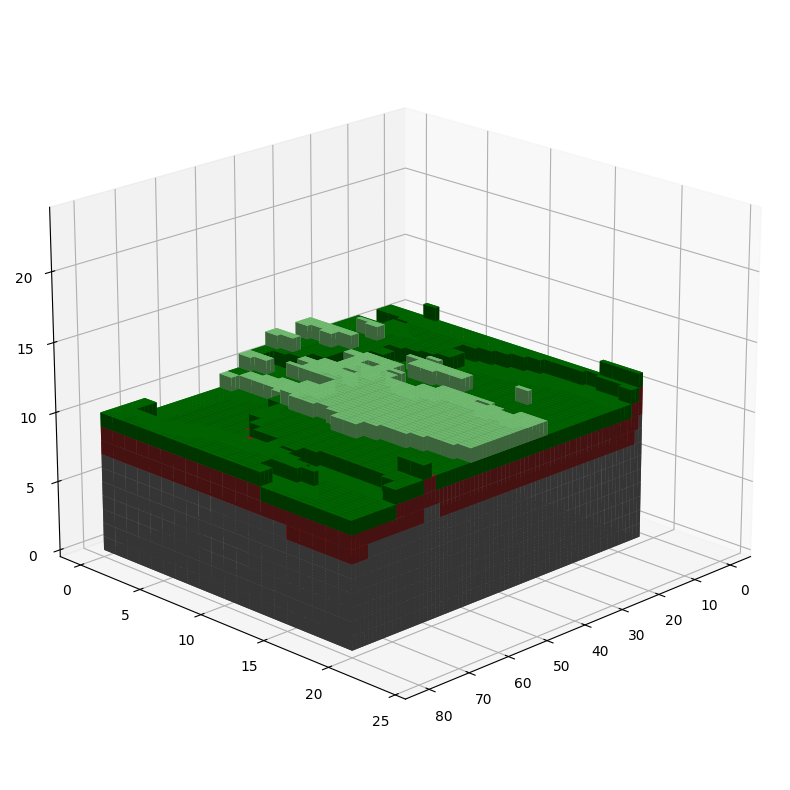

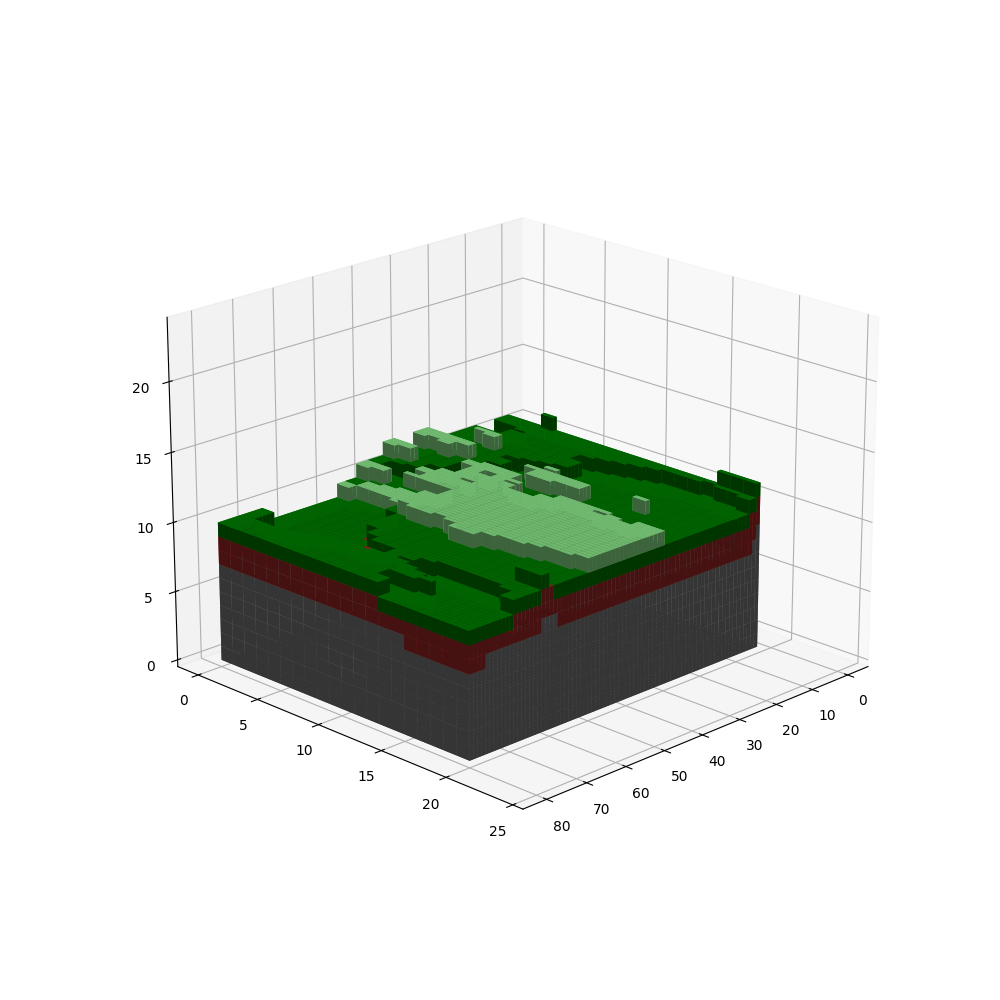

In [16]:
visualize_chunk(blocks[3])

# Make super sample gif from starting latent

In [19]:
base_latent = torch.load("sample_latent_2.pt").squeeze(0)
desired_shape = (12, 6, 6)  # Extending in the Y direction
super_sample = outpaint_latent_edge(visualizer.sampler,base_latent, desired_shape, time_steps=desired_shape[0] * desired_shape[1] * desired_shape[2] )

100%|██████████| 432/432 [00:15<00:00, 28.38it/s]


In [20]:
generated_blocks = process_super_sampled_latents(super_sample, visualizer.sampler, visualizer.generator, visualizer.H)
blocks = torch.argmax(generated_blocks, dim=1)  # dim=1 should be the block type dimension
print(f'blocks shape: {blocks.shape}')
# Convert to original block IDs
blocks = visualizer.block_converter.convert_to_original_blocks(blocks)
print(blocks[0].shape)

Latents shape: torch.Size([1, 12, 6, 6])
One-hot shape: torch.Size([1, 432, 512])
Embedded shape: torch.Size([1, 256, 12, 6, 6])
blocks shape: torch.Size([1, 48, 24, 24])
torch.Size([48, 24, 24])


In [21]:
super_sample_instance = super_sample[0]
slices_blocks = []
n_slices = super_sample_instance.shape[0] - 6
max_x = 24
max_y = 24
for i in range(n_slices + 1):
    slice = super_sample_instance[:6 + i, :, :]
    print(f'slice shape: {slice.shape}')
    slice_gen_blocks = process_super_sampled_latents(slice, visualizer.sampler, visualizer.generator, visualizer.H)
    print(f'slice_gen_blocks shape: {slice_gen_blocks.shape}')
    slice_gen_blocks = torch.argmax(slice_gen_blocks, dim=1)  # dim=1 should be the block type dimension
    print(f'argmaxed: {slice_gen_blocks.shape}')
    slice_gen_blocks = visualizer.block_converter.convert_to_original_blocks(slice_gen_blocks)
    print(f'converted: {slice_gen_blocks.shape}')
    if slice_gen_blocks.shape[1] > max_x:
        max_x = slice_gen_blocks.shape[1]
    if slice_gen_blocks.shape[2] > max_y:
        max_x = slice_gen_blocks.shape[2]
    # visualize_chunk_super(slice_gen_blocks[0], desired_shape, max_x=44)
    slices_blocks.append(slice_gen_blocks)


slice shape: torch.Size([6, 6, 6])
Latents shape: torch.Size([1, 6, 6, 6])
One-hot shape: torch.Size([1, 216, 512])
Embedded shape: torch.Size([1, 256, 6, 6, 6])
slice_gen_blocks shape: torch.Size([1, 39, 24, 24, 24])
argmaxed: torch.Size([1, 24, 24, 24])
converted: torch.Size([1, 24, 24, 24])
slice shape: torch.Size([7, 6, 6])
Latents shape: torch.Size([1, 7, 6, 6])
One-hot shape: torch.Size([1, 252, 512])
Embedded shape: torch.Size([1, 256, 7, 6, 6])
slice_gen_blocks shape: torch.Size([1, 39, 28, 24, 24])
argmaxed: torch.Size([1, 28, 24, 24])
converted: torch.Size([1, 28, 24, 24])
slice shape: torch.Size([8, 6, 6])
Latents shape: torch.Size([1, 8, 6, 6])
One-hot shape: torch.Size([1, 288, 512])
Embedded shape: torch.Size([1, 256, 8, 6, 6])
slice_gen_blocks shape: torch.Size([1, 39, 32, 24, 24])
argmaxed: torch.Size([1, 32, 24, 24])
converted: torch.Size([1, 32, 24, 24])
slice shape: torch.Size([9, 6, 6])
Latents shape: torch.Size([1, 9, 6, 6])
One-hot shape: torch.Size([1, 324, 512])

In [60]:
max_x

48

In [17]:
generate_growing_gif(slices_blocks, desired_shape, output_path='super_sample_latent2_4.gif', max_x=max_x, max_y=max_y)

Generating growing visualization...
Generating 7 frames...


C:\Users\TimBits\AppData\Local\Temp\ipykernel_10044\1895645499.py:66: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processed frame 1/7
Processed frame 2/7
Processed frame 3/7
Processed frame 4/7
Processed frame 5/7
Processed frame 6/7
Processed frame 7/7
Saving GIF to super_sample_latent2_3.gif
Done!


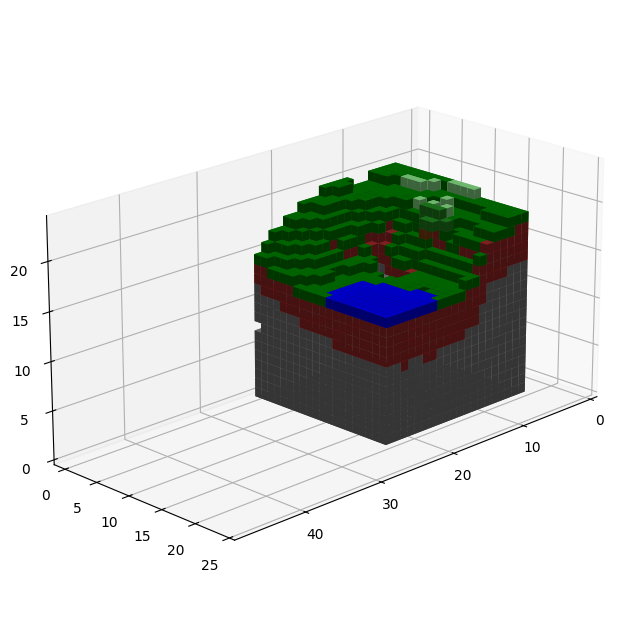

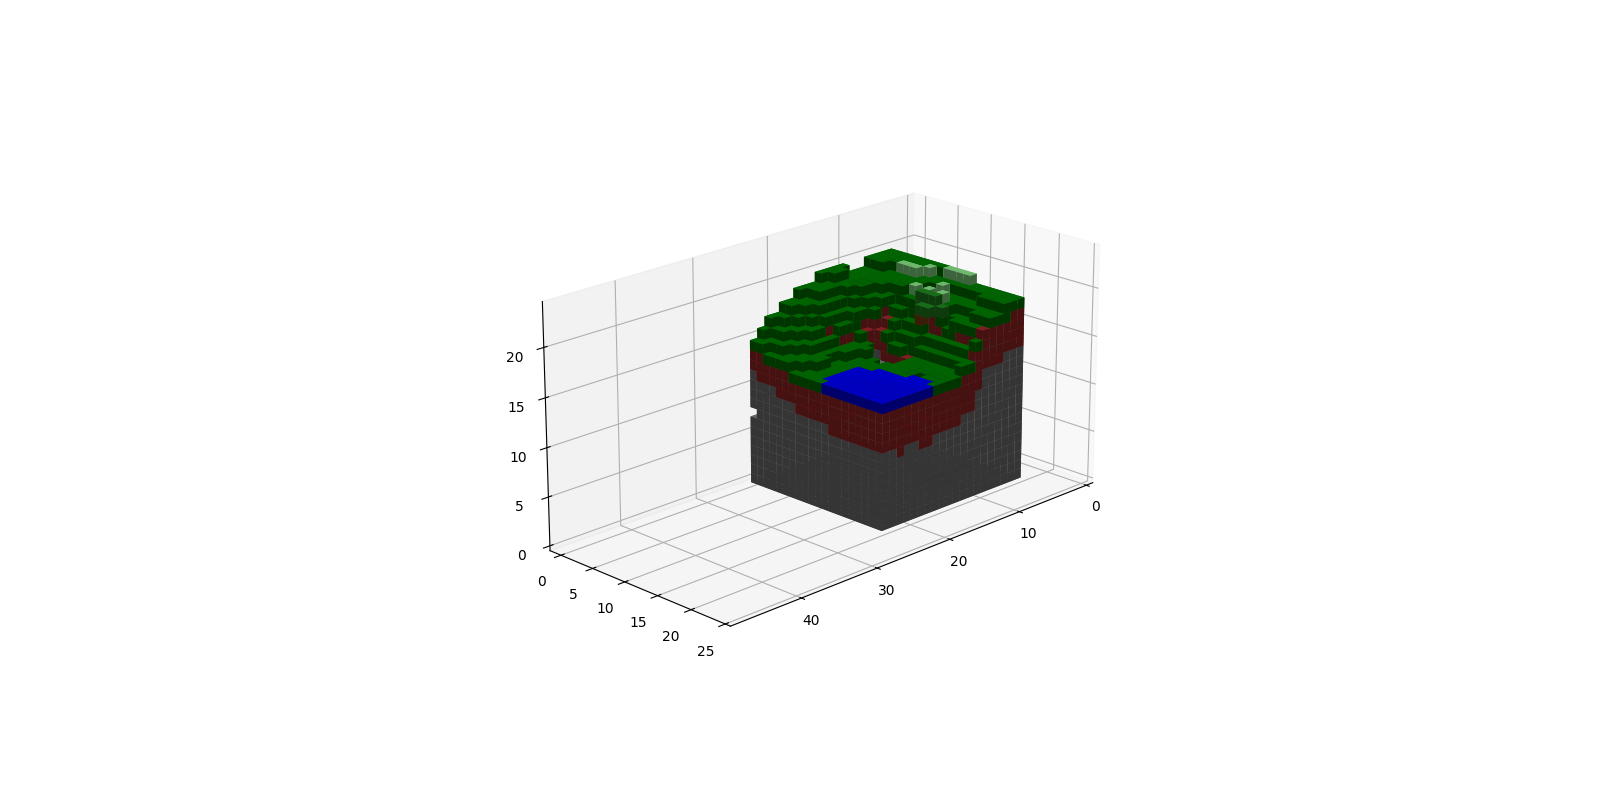

In [14]:
mask = torch.ones_like(base_latent, dtype=torch.bool)
base_sample_blocks = visualizer.latents_to_blocks(base_latent, mask)
visualize_chunk_super(base_sample_blocks[0], desired_shape, max_x=48)

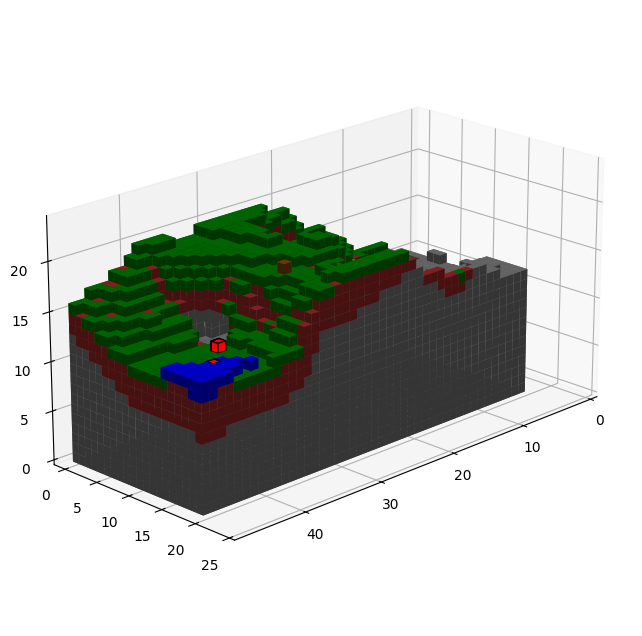

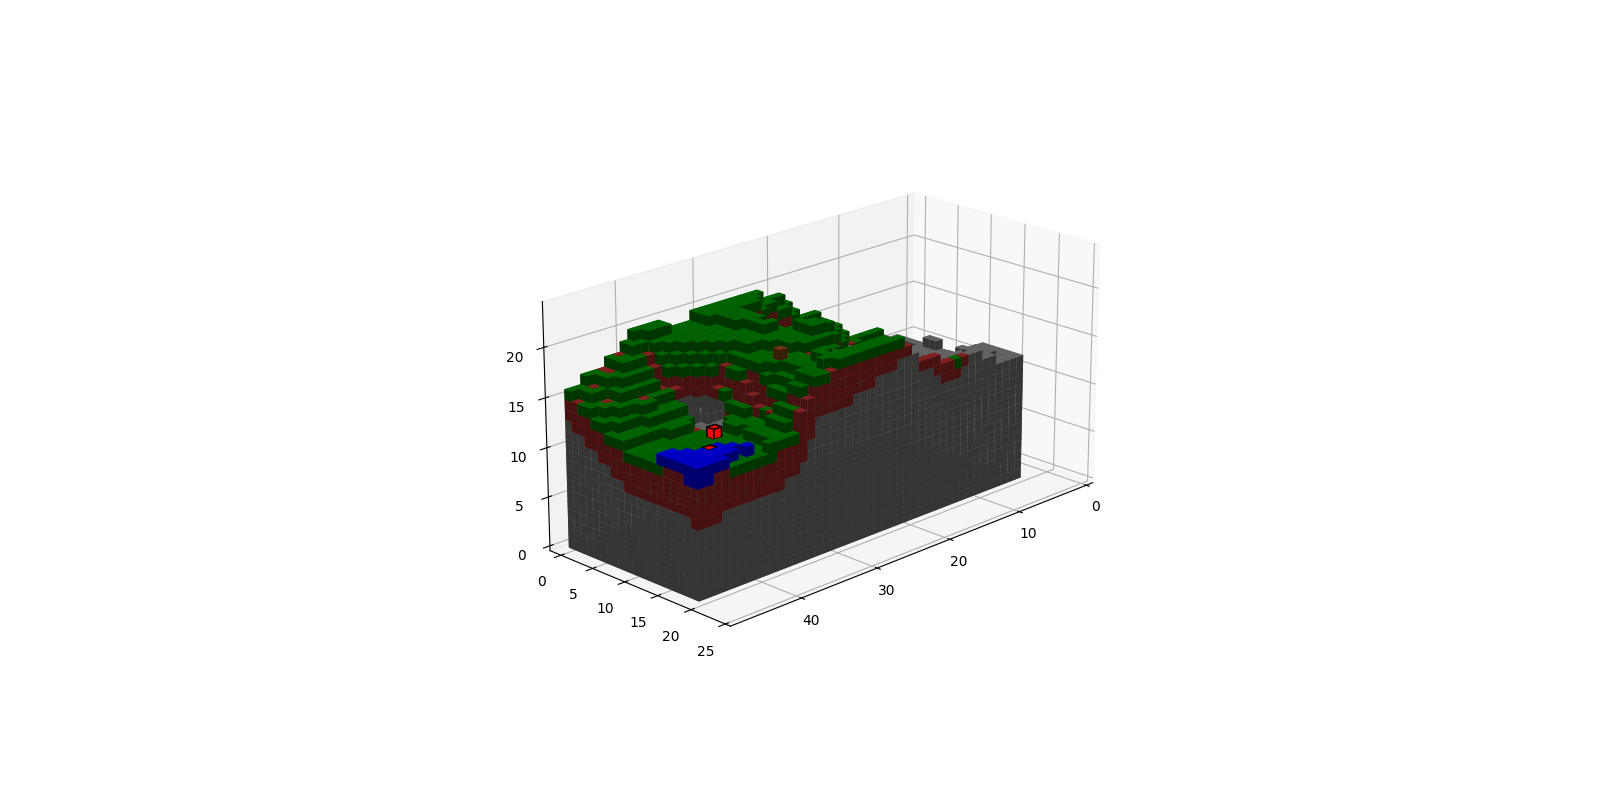

In [15]:
visualize_chunk_super(blocks[0], desired_shape, max_x=48)